Example using mnist
https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py

Geron Text about Classifiers: https://www.lpsm.paris/pageperso/has/source/Hand-on-ML.pdf

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib

In [19]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

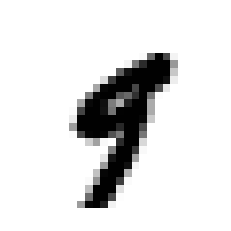

In [25]:
#looking at one of the digits in the dataset
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
 interpolation="nearest")
plt.axis("off")
plt.show()

In [26]:
#looks like a 9, let check
y[36000]

'9'

In [27]:
#creating train/test split data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [38]:
np.unique(y_train_5)

array([False,  True])

In [32]:
#What happened is that you used fetch_openml() to download MNIST, and it returns 
#labels as strings so when you defined y_train_5 = (y_train == 5), it results an array full of False. See above cell.
#Fix
y_train = y_train.astype(np.int8)

In [35]:
np.unique(y_train_5)

array([False,  True])

In [28]:
#shuffling training set to guarantee that all cross-validation folds will
#be similar (you don’t want one fold to be missing some digits)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

Try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. 

In [33]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)


In [34]:
# Let’s create an SGDClassifier and train it on the whole training set:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
 sgd_clf.predict([some_digit])

array([False])

#### Performance Measures

#### Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what
cross_val_score() and similar functions provide. In these cases, you can implement
cross-validation yourself; it is actually fairly straightforward. The following code does
roughly the same thing as the preceding cross_val_score() code, and prints the
same result:


In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96755
0.96735
0.8676


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [41]:
# Using cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds.
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96755, 0.96735, 0.8676 ])